In [1]:
# Imports and set torch device
import numpy as np
import meshplot as mp
import torch
import matplotlib.pyplot as plt
import kaolin as kal
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print('Torch will run on:', device)

object = 'bed' 
obj_path = 'data/demo/' + object + '.obj'

Torch will run on: cuda:0


In [2]:
# Read mesh
mesh = kal.io.obj.import_mesh(
    obj_path,
    with_normals=True,
    with_materials=False,
)

vertices_tensor = mesh.vertices.to(device)
faces_tensor = mesh.faces.to(device)

vertices = vertices_tensor.detach().cpu().numpy()
faces = faces_tensor.detach().cpu().numpy()
color =  mesh.vertex_normals.cpu().numpy()

print('Number of vertices: ', vertices.shape[0])
print('Number of faces: ', faces.shape[0])

Number of vertices:  11973
Number of faces:  19568


In [3]:
# Visualize mesh
mp.plot(vertices, faces, color)
plt.show()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.001309…

In [4]:
from meshseg.renderer.renderer import Renderer
from meshseg.mesh import Mesh

myMesh = Mesh('data/demo/' + object + '.obj')

render = Renderer(dim=(1024, 1024))
rendered_images, elev, azim, _, faces_idx = render.render_views(
            None,
            None,
            2,
            myMesh,
            num_views=1,
            show=False,
            center_azim=3.14,
            center_elev=0,
            std=4,
            return_views=True,
            return_mask=True,
            return_face_idx=True,
            lighting=True,
            background=torch.tensor([255.,255.,255.]).to(device),
            seed=2023,
            random_rendering=False
        )

In [5]:
faces_idx_np = faces_idx[0].flatten().cpu().int().numpy()
faces_idx_np = faces_idx_np[faces_idx_np != -1]
print(faces_idx_np.shape)

(607745,)


In [6]:
def get_camera_from_view2(elev, azim, r=3.0):
    x = r * torch.cos(elev) * torch.cos(azim)
    y = r * torch.sin(elev)
    z = r * torch.cos(elev) * torch.sin(azim)
    pos = torch.tensor([x, y, z]).unsqueeze(0)
    look_at = -pos
    direction = torch.tensor([0.0, 1.0, 0.0]).unsqueeze(0)

    camera_proj = kal.render.camera.generate_transformation_matrix(pos, look_at, direction)
    return camera_proj


def render_view(elev, azim, r):
    background = torch.tensor([255.0, 255.0, 255.0]).to(device)
    # face_attributes = kal.ops.mesh.index_vertices_by_faces(
    #     torch.ones(1, len(mesh.vertices), 3).to(device)
    #     * torch.tensor([0.5, 0.5, 0.5]).unsqueeze(0).unsqueeze(0).to(device),
    #     faces_tensor,
    # )
    face_attributes = kal.ops.mesh.index_vertices_by_faces(
            mesh.vertex_normals.unsqueeze(0).to(device),
            faces_tensor
    ) 
    face_attributes = [
        face_attributes,  # Colors
        torch.ones((1, faces.shape[0], 3, 1), device=device),  # hard seg. mask
    ]
    
    camera_projection = kal.render.camera.generate_perspective_projection(np.pi / 3).to(
                    device
                )
    camera_transform = get_camera_from_view2(elev, azim, r=r).to(device)
    (
        face_vertices_camera,
        face_vertices_image,
        face_normals,
    ) = kal.render.mesh.prepare_vertices(
        mesh.vertices.to(device),
        mesh.faces.to(device),
        camera_projection,
        camera_transform=camera_transform,
    )

    image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
        1024,
        1024,
        face_vertices_camera[:, :, :, -1],
        face_vertices_image,
        face_attributes,
        face_normals[:, :, -1],
    )
    image_features, mask = image_features
    image = torch.clamp(image_features, 0.0, 1.0)
    lights=torch.tensor([1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]).unsqueeze(0).to(device)
    image_normals = face_normals[:, face_idx].squeeze(0)
    image_lighting = kal.render.mesh.spherical_harmonic_lighting(
        image_normals, lights
        ).unsqueeze(0)
    image = image * image_lighting.repeat(1, 3, 1, 1).permute(
        0, 2, 3, 1
        ).to(device)
    image = torch.clamp(image, 0.0, 1.0)
    background_mask = torch.zeros(image.shape).to(device)
    mask = mask.squeeze(-1)
    background_idx = torch.where(mask == 0)
    assert torch.all(
        image[background_idx] == torch.zeros(3).to(device)
    )  # Remvoe it may be taking a lot of time
    background_mask[
        background_idx
    ] = background  # .repeat(background_idx[0].shape)
    image = torch.clamp(image + background_mask, 0.0, 1.0)
    image = image.squeeze().cpu().numpy()
    image *= 255.0
    image = image.astype(np.uint8)
    return image

In [7]:
from SAM import SamPredictor, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="./SAM/MODEL/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


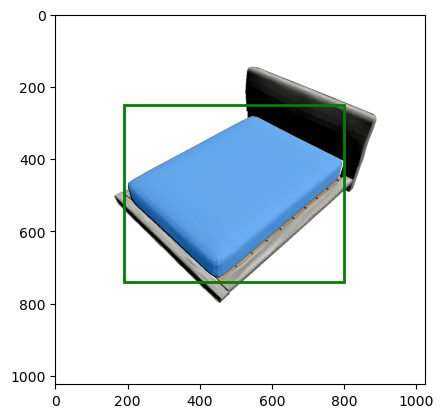

In [8]:
elev = torch.deg2rad(torch.tensor(45)).to(device)
azim = torch.deg2rad(torch.tensor(45)).to(device)
image = render_view(elev, azim, 4)
predictor.set_image(image)
input_box = np.array([190, 250, 800, 740])
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)
plt.figure()
plt.imshow(image)
show_box(input_box, plt.gca())
show_mask(masks[0], plt.gca())
plt.show()

In [ ]:
elev = torch.deg2rad(torch.tensor(10)).to(device)
azim = torch.deg2rad(torch.tensor(90)).to(device)
image = render_view(elev, azim, 3)
predictor.set_image(image)
input_box = np.array([170, 320, 860, 580])
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)
plt.figure()
plt.imshow(image)
show_box(input_box, plt.gca())
show_mask(masks[0], plt.gca())
plt.show()

In [ ]:
elev = torch.deg2rad(torch.tensor(10)).to(device)
azim = torch.deg2rad(torch.tensor(90)).to(device)
image = render_view(elev, azim, 3)
predictor.set_image(image)
input_box = np.array([130, 540, 170, 620])
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)
plt.figure()
plt.imshow(image)
show_box(input_box, plt.gca())
show_mask(masks[0], plt.gca())
plt.show()

In [ ]:
elev = torch.deg2rad(torch.tensor(20)).to(device)
azim = torch.deg2rad(torch.tensor(150)).to(device)
image = render_view(elev, azim, 3)
predictor.set_image(image)
input_box = np.array([10, 150, 420, 570])
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)
plt.figure()
plt.imshow(image)
show_box(input_box, plt.gca())
show_mask(masks[0], plt.gca())
plt.show()

In [ ]:
object = 'bed' 
obj_path = 'data/demo/' + object + '.obj'
# Read mesh
mesh = kal.io.obj.import_mesh(
    obj_path,
    with_normals=True,
    with_materials=False,
)

vertices = mesh.vertices.cpu().numpy()
faces = mesh.faces.cpu().numpy()

elev = torch.deg2rad(torch.tensor(40)).to(device)
azim = torch.deg2rad(torch.tensor(120)).to(device)
r = 2
x = r * torch.cos(elev) * torch.cos(azim)
y = r * torch.sin(elev)
z = r * torch.cos(elev) * torch.sin(azim)

pos = torch.tensor([x, y, z]).unsqueeze(0)
look_at = torch.mean(mesh.vertices, axis=0) - pos
direction = torch.tensor([0.0, 1.0, 0.0]).unsqueeze(0)

camera_transform = kal.render.camera.generate_transformation_matrix(pos, look_at, direction)
camera_projection = kal.render.camera.generate_perspective_projection(np.pi / 3).to(device)
(
    face_vertices_camera,
    face_vertices_image,
    face_normals,
) = kal.render.mesh.prepare_vertices(
    mesh.vertices.to(device),
    mesh.faces.to(device),
    camera_projection,
    camera_transform=camera_transform,
)

